# The influence of weather on bike-sharing
## Sources of datasets:

[London weather data](https://www.kaggle.com/datasets/noahx1/london-weather-2000-2023)

[Bike-Share Usage in London and Taipei Network](https://www.kaggle.com/datasets/ajohrn/bikeshare-usage-in-london-and-taipei-network/data)

### Things to do to run:
* Download these three datasets: London.csv, London_stations.csv (source 2) & london0_23_weather_data.csv (source 1)
* Place the files together with this code in a shared folder

To run the code (in VSC):
* Make sure you have Python installed (I'm using Python 3.11.9)
* To the upper right here, select this Python as kernel
* It migh be that you still need to select an environment to run the code, use .venv
* In the cell below: uncomment the pip-commands (only run this once, then comment them again)
* It should work now :)

## Installing and defining names and files

In [1]:
#pip install pandas

In [2]:
#pip install seaborn

In [3]:
#pip install scikit-learn

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#We only look at the London-data (there is also data from Taipei network)
df_london = pd.read_csv('london.csv', parse_dates=[3,6], infer_datetime_format=True)
df_london.shape

C:\Users\arthu\AppData\Local\Temp\ipykernel_21764\2391621177.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_london = pd.read_csv('london.csv', parse_dates=[3,6], infer_datetime_format=True)


(38215560, 9)

In [6]:
#import the names of the stations (a bit easier to identify stations later)
df_london_geo = pd.read_csv('london_stations.csv')


In [7]:
#import weather data of London (this goes from 2000-2023, so we can discard a lot later)
df_london_weather = pd.read_csv('london0_23_weather_data.csv')

#Deleting NaN's
df_london_weather = df_london_weather.drop('tsun', axis=1)
df_london_weather = df_london_weather.drop('wpgt', axis=1)
df_london_weather['snow'] = df_london_weather['snow'].fillna(0)
df_london_weather['prcp'] = df_london_weather['prcp'].fillna(0)
    # Interpolate the other missing values linearly
df_london_weather = df_london_weather.interpolate(method='linear')
df_london_weather.loc[0, 'wdir'] = 255

#Since there is no explicit date column, I create one for our ease (starting from 01-01-2000):
df_london_weather['date'] = pd.date_range(start='2000-01-01', periods=len(df_london_weather), freq='D') 
# Extract useful time-related features
df_london_weather['day'] = df_london_weather['date'].dt.day
df_london_weather['month'] = df_london_weather['date'].dt.month
df_london_weather['week'] = df_london_weather['date'].dt.isocalendar().week
df_london_weather['dayofweek'] = df_london_weather['date'].dt.dayofweek
df_london_weather['year'] = df_london_weather['date'].dt.year
df_london_weather['satsun'] = df_london_weather['dayofweek'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5: True, 6:True})

# Display the first few rows
df_london_weather.head(8)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,date,day,month,week,dayofweek,year,satsun
0,7.3,3.1,9.000000,1.8,0.0,255.0,2.3,1024.5,2000-01-01,1,1,52,5,2000,True
1,9.5,8.0,11.000000,0.0,0.0,225.0,11.6,1025.2,2000-01-02,2,1,52,6,2000,True
2,9.4,5.6,11.200000,2.0,0.0,233.0,16.8,1018.5,2000-01-03,3,1,1,0,2000,False
3,5.7,2.8,9.500000,3.8,0.0,229.0,17.0,1014.8,2000-01-04,4,1,1,1,2000,False
4,7.1,1.9,10.066667,0.0,0.0,225.0,17.2,1015.6,2000-01-05,5,1,1,2,2000,False
5,8.8,3.8,10.633333,0.0,0.0,221.0,17.4,1016.4,2000-01-06,6,1,1,3,2000,False
6,8.8,5.7,11.200000,0.0,0.0,217.0,17.6,1017.2,2000-01-07,7,1,1,4,2000,False
7,8.3,5.5,10.300000,0.0,0.0,241.0,16.3,1016.4,2000-01-08,8,1,1,5,2000,True


In [8]:
#The data includes rare rental events that are started but not ended. For this analysis these are best removed.
df_london = df_london.loc[~df_london.isnull().any(axis=1)]
df_london = df_london.astype({'bike_id' : 'int32', 'end_station_id' : 'int32', 'start_station_id' : 'int32'})
df_london.shape

(38147278, 9)

In [9]:
#Augment datetime data to make it easier for binning and applying conditions with respect to time.
df_london.loc[:, 'year'] = df_london['start_rental_date_time'].dt.year
df_london.loc[:, 'month'] = df_london['start_rental_date_time'].dt.month
df_london.loc[:, 'week'] = df_london['start_rental_date_time'].dt.isocalendar().week
df_london.loc[:, 'day'] = df_london['start_rental_date_time'].dt.day
df_london.loc[:, 'hour'] = df_london['start_rental_date_time'].dt.hour
df_london.loc[:, 'dayofweek'] = df_london['start_rental_date_time'].dt.dayofweek
df_london.loc[:, 'satsun'] = df_london['dayofweek'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5: True, 6:True})
df_london.shape
df_london.head(3)

,rental_id,duration,bike_id,end_rental_date_time,end_station_id,end_station_name,start_rental_date_time,start_station_id,start_station_name,year,month,week,day,hour,dayofweek,satsun
0,61343322,60.0,12871,2016-12-28 00:01:00,660,"West Kensington Station, West Kensington",2016-12-28,633,"Vereker Road North, West Kensington",2016,12,52,28,0,2,False
1,61343321,300.0,2837,2016-12-28 00:05:00,763,"Mile End Park Leisure Centre, Mile End",2016-12-28,531,"Twig Folly Bridge, Mile End",2016,12,52,28,0,2,False
2,61343323,360.0,1269,2016-12-28 00:06:00,99,"Old Quebec Street, Marylebone",2016-12-28,116,"Little Argyll Street, West End",2016,12,52,28,0,2,False


In [10]:
#A handful of stations are very rarely part of any rental events. 
#In some cases these are temporary stations or stations that become decommissioned. 
#In some analysis these low count stations are best removed.

below_or_above_stations = df_london['start_station_name'].value_counts() < 500
low_stations = below_or_above_stations.loc[below_or_above_stations].index
df_london = df_london.loc[~df_london['start_station_name'].isin(low_stations)]
df_london = df_london.loc[~df_london['end_station_name'].isin(low_stations)]
df_london.shape

(38144414, 16)

[Text(0, 0.5, 'number of rentals')]

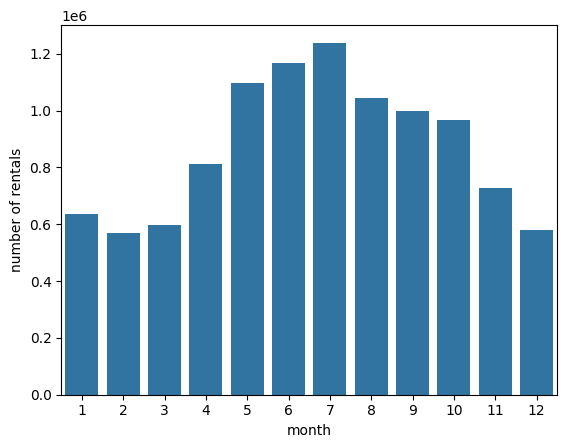

In [11]:
#small test: the number of rental events in the months of a particular year, say 2018
per_month_2018_group = df_london.loc[df_london['year'] == 2018].groupby('month')
month_counts = per_month_2018_group.count()

ax=sns.barplot(x=month_counts.index, y=month_counts.iloc[:,0])
ax.set(ylabel='number of rentals')

<Axes: xlabel='hour'>

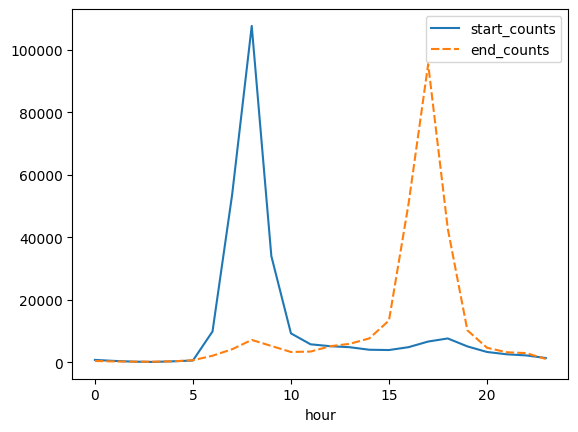

In [12]:
weekday_14_start = df_london.loc[(df_london['start_station_id'] == 14) & (df_london['satsun'] == False)] # only weekdays for station 14
weekday_14_end = df_london.loc[(df_london['end_station_id'] == 14) & (df_london['satsun'] == False)]
weekday_14_start = weekday_14_start.groupby('hour').count()
weekday_14_end = weekday_14_end.groupby('hour').count()
weekday_14_data = pd.DataFrame({'start_counts' : weekday_14_start.iloc[:,0],
                                'end_counts' : weekday_14_end.iloc[:,0]})

sns.lineplot(data=weekday_14_data)

## The analysis

Although we might strongly suspect a correlation between weather and bike usage, I will first plot both their values to see if we see a (rough) correlation. This has still nothing to do with the data-driven part

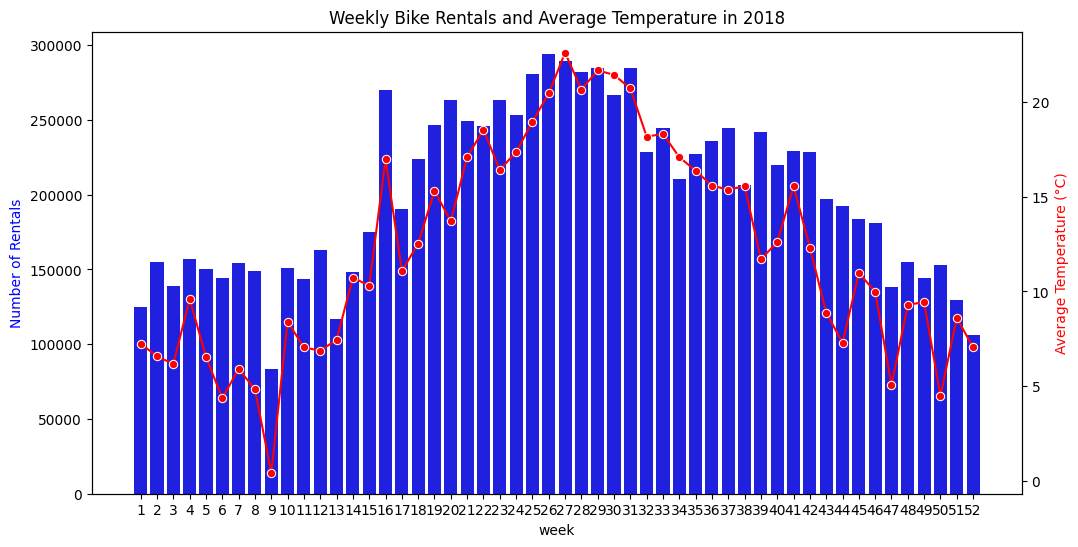

In [13]:
#Let's do it for each week in 2018
#Total number of bike rentals in the week:
per_week_2018_group = df_london.loc[df_london['year'] == 2018].groupby('week')
week_counts = per_week_2018_group.count()

# Compute the average temperature for each whole week of 2018
df_2018 = df_london_weather[df_london_weather['year'] == 2018]
avg_weekly_temp_2018 = df_2018.groupby('week')['tavg'].mean()

#Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(x=week_counts.index, y=week_counts.iloc[:,0], color='b', ax=ax1)
ax1.set_ylabel('Number of Rentals', color='b')

ax2 = ax1.twinx()
sns.lineplot(x=avg_weekly_temp_2018.index-1, y=avg_weekly_temp_2018, color='r', marker='o', ax=ax2)
ax2.set_ylabel('Average Temperature (°C)', color='r')

plt.title('Weekly Bike Rentals and Average Temperature in 2018')
plt.show()

I think we can conclude that there might definitely be a correlation between the average temperature and the number of bike rentals (clear for example in week 9 and 16)

### Just some ideas: 
We might see all weather-elements of a day as 'variables' and the number of bike-rides of a day as 'output'. We could do a PCA on these?

I don't know if we saw anything of this in class, but you might see all stations as nodes and the bikerides inbetween them as links. This way you can create a graph and show which stations are the most important (I mean from where to where is most driven), there is a kind of example of this in here: https://towardsdatascience.com/london-bike-ride-forecasting-with-graph-convolutional-networks-aee044e48131/

Creating a Neural Network to forecast the bike usage based on the data of the weather (of the same day, or maybe of the day before idk?)

Other ideas are welcome :)

### PCA on Weather data
I tried to get to 3 PCA's instead of 8. This gets us to 69,5%

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


start_data = df_london_weather.loc[:, 'tavg':'pres']
weather_features = start_data.columns.to_list()
n_features = len(weather_features)
start_data.head(8)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres
0,7.3,3.1,9.000000,1.8,0.0,255.0,2.3,1024.5
1,9.5,8.0,11.000000,0.0,0.0,225.0,11.6,1025.2
2,9.4,5.6,11.200000,2.0,0.0,233.0,16.8,1018.5
3,5.7,2.8,9.500000,3.8,0.0,229.0,17.0,1014.8
4,7.1,1.9,10.066667,0.0,0.0,225.0,17.2,1015.6
5,8.8,3.8,10.633333,0.0,0.0,221.0,17.4,1016.4
6,8.8,5.7,11.200000,0.0,0.0,217.0,17.6,1017.2
7,8.3,5.5,10.300000,0.0,0.0,241.0,16.3,1016.4


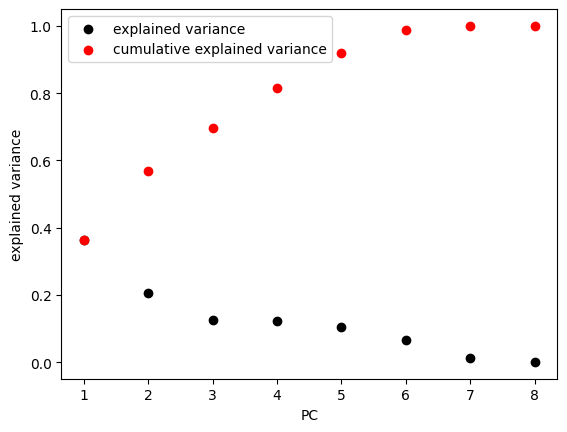

In [15]:
scaler = StandardScaler()
start_data_0 = scaler.fit_transform(start_data)

pca = PCA(n_components=n_features) #all featuresbecause we want to look at eigvals distribution
pca.fit_transform(start_data_0)

A = pca.components_.T
Z = start_data_0 @ A
ex_var = pca.explained_variance_ratio_
cum_ex_var = np.cumsum(ex_var)

plt.scatter(1+np.arange(n_features), ex_var, c='k', label='explained variance')
plt.scatter(1+np.arange(n_features), cum_ex_var, c='r', label='cumulative explained variance')
plt.xlabel('PC')
plt.ylabel('explained variance')
plt.legend()
plt.show()

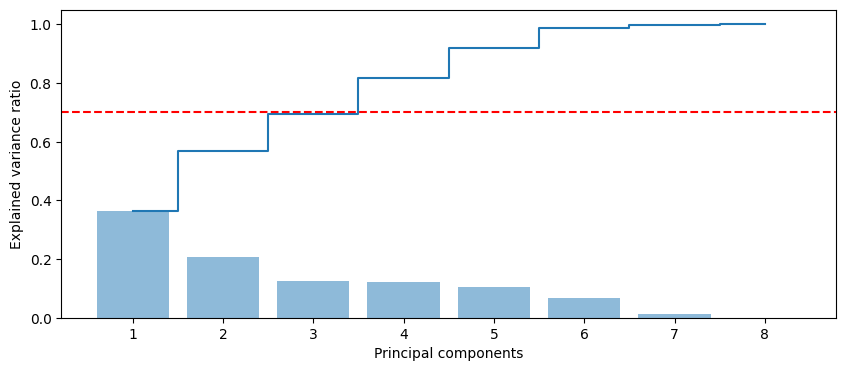

Explained variance per component:
PC1: 0.363 (0.363 cumulative)
PC2: 0.206 (0.569 cumulative)
PC3: 0.126 (0.695 cumulative)
PC4: 0.122 (0.817 cumulative)
PC5: 0.104 (0.920 cumulative)
PC6: 0.067 (0.987 cumulative)
PC7: 0.012 (0.999 cumulative)
PC8: 0.001 (1.000 cumulative)


In [16]:
# Fit PCA and examine explained variance
pca = PCA()
pca.fit(start_data_0)  # start_data_0 is your standardized weather data

# Plot the explained variance
plt.figure(figsize=(10, 4))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.axhline(y=0.7, color='r', linestyle='--')  # 70% variance threshold
plt.show()

# Print explained variance
print("Explained variance per component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.3f} ({np.cumsum(pca.explained_variance_ratio_)[i]:.3f} cumulative)")

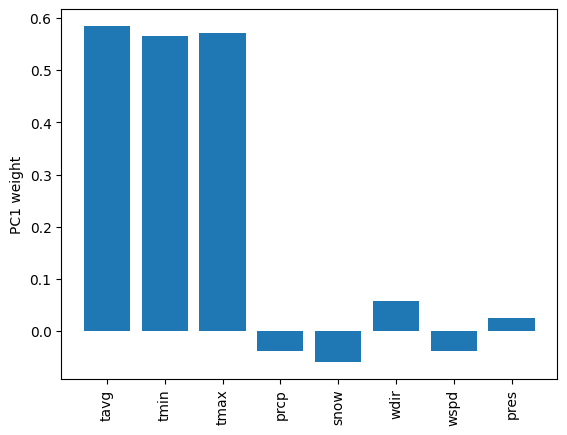

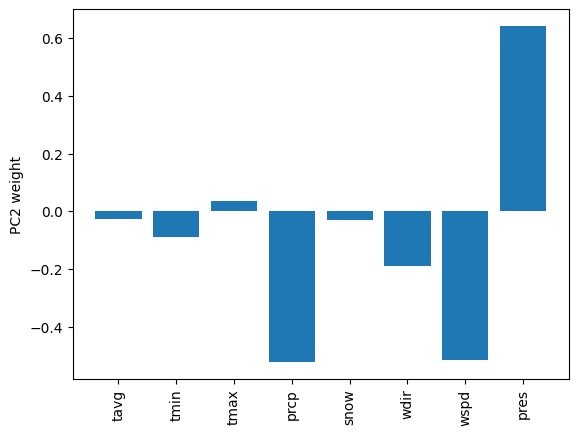

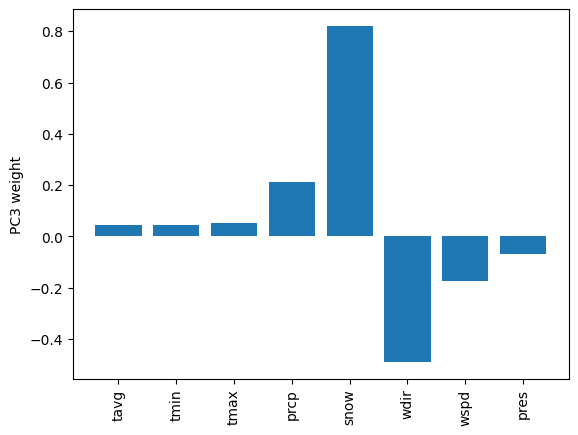

In [17]:
plt.bar(np.arange(n_features), A[:, 0])
plt.xticks(np.arange(n_features), weather_features, rotation=90)
plt.ylabel('PC1 weight')
plt.show()

plt.bar(np.arange(n_features), A[:, 1])
plt.xticks(np.arange(n_features), weather_features, rotation=90)
plt.ylabel('PC2 weight')
plt.show()

plt.bar(np.arange(n_features), A[:, 2])
plt.xticks(np.arange(n_features), weather_features, rotation=90)
plt.ylabel('PC3 weight')
plt.show()

The clustering doesn't tell us much, but I did it anyway just to test

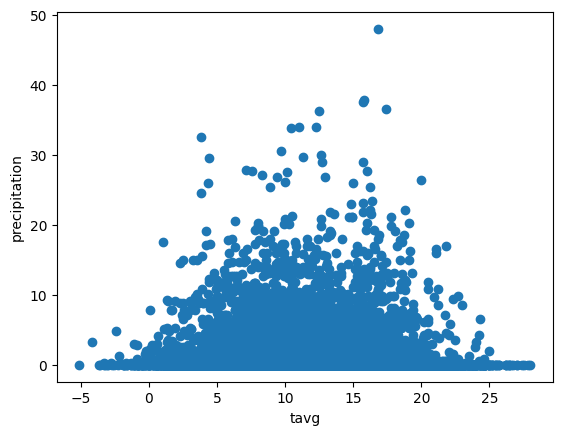

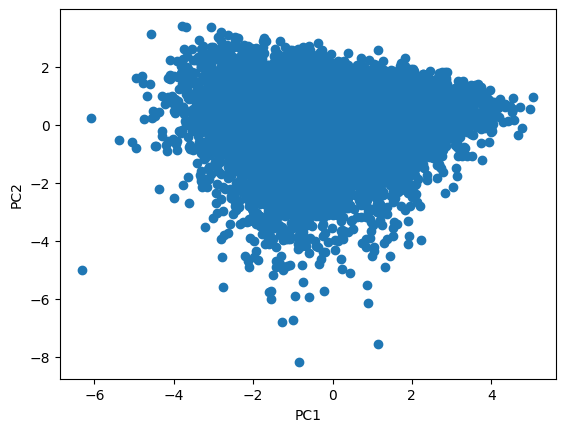

In [18]:
plt.scatter(start_data.loc[:, 'tavg'], start_data.loc[:, 'prcp']) #bad clustering
plt.xlabel('tavg')
plt.ylabel('precipitation')
plt.show()

plt.scatter(Z[:, 0], Z[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show() #better clustering

### Data Integration:
Here we merge both database to find some correlation between them afterwards.

In [28]:
# Convert 'start_rental_date_time' to date (if not already done)
df_london['date'] = df_london['start_rental_date_time'].dt.date  

# Aggregate total rentals per day
daily_rentals = df_london.groupby('date').size().reset_index(name='rental_count')  
daily_rentals.head(3)  
# Ensure weather 'date' column is in date format (if not already done)
df_london_weather['date'] = pd.to_datetime(df_london_weather['date']).dt.date 

In [20]:
# Refit PCA with optimal number of components (3 PCA's)
n_optimal = 3  # Set based on explained variance plot
pca = PCA(n_components=n_optimal)
pca_transformed = pca.fit_transform(start_data_0)

# Create DataFrame with selected PCs
pca_df = pd.DataFrame(pca_transformed, columns=[f'weather_pc{i+1}' for i in range(n_optimal)])
pca_df['date'] = pd.to_datetime(df_london_weather['date']).dt.date

In [29]:
# First ensure we only keep PCA rows that match rental dates
# Get the dates that exist in both datasets
common_dates = set(daily_rentals['date']).intersection(set(pca_df['date']))

# Filter DataFrames
pca_df_filtered = pca_df[pca_df['date'].isin(common_dates)]
weather_df_filtered = df_london_weather[df_london_weather['date'].isin(common_dates)]
daily_rentals_filtered = daily_rentals[daily_rentals['date'].isin(common_dates)]

In [22]:
# Merge on 'date'
merged_data = pd.merge(daily_rentals_filtered, pca_df_filtered, on='date', how='inner')  

# Verify lengths match
print(f"Bike rental records: {len(daily_rentals_filtered)}")
print(f"PCA weather records: {len(pca_df_filtered)}")
print(f"Merged records: {len(merged_data)}")

# Show PCA results
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Number of components kept:", pca.n_components_) 

merged_data.head(3)  

Bike rental records: 1344
PCA weather records: 1344
Merged records: 1344
Explained variance ratio: [0.36289502 0.20620928 0.1258539 ]
Number of components kept: 3


,date,rental_count,weather_pc1,weather_pc2,weather_pc3
0,2016-12-28,12387,-2.892950,3.012404,0.416180
1,2016-12-29,14012,-2.226310,2.742126,0.434245
2,2016-12-30,11537,-2.680771,2.031718,-0.602511



PCA Component Loadings:
         tavg      tmin      tmax      prcp      snow      wdir      wspd  \
PC1  0.584830  0.565740  0.572261 -0.038217 -0.060481  0.057023 -0.038569   
PC2 -0.025355 -0.090785  0.034818 -0.523547 -0.029569 -0.189304 -0.516478   
PC3  0.044191  0.044272  0.051879  0.212501  0.819861 -0.490528 -0.175087   

         pres  
PC1  0.023893  
PC2  0.642138  
PC3 -0.069233  


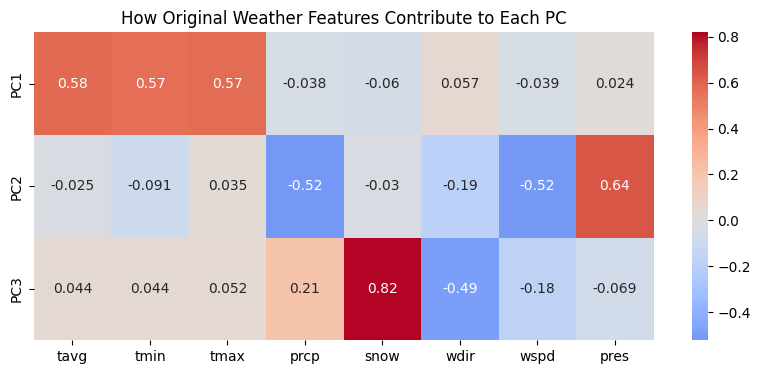

In [ ]:
# Show how original features contribute to each PC (this is actually the same as the bar-plots before)
loadings = pd.DataFrame(
    pca.components_,
    columns=start_data.columns,
    index=[f'PC{i+1}' for i in range(n_optimal)]
)

print("\nPCA Component Loadings:")
print(loadings)

# Visualize loadings
plt.figure(figsize=(10, 4))
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=True)
plt.title("How Original Weather Features Contribute to Each PC")
plt.show()

In [ ]:
#Note Arthur: I believe this whole block is not very useful. It is not actually allowed to give meanings to PCA's

# Create loadings DataFrame with interpretation
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to match standard format
    columns=['PC1', 'PC2', 'PC3'],
    index=start_data.columns
)

# Add interpretation notes (note Arthur: I think this is a bit wrong. PCA 1 Is pure Temp, PCA3 Only depends on snow and wdir, not pressure or temp)
interpretation = {
    'PC1': "Overall Weather Quality (Higher = Better)",
    'PC2': "Precipitation vs Wind Trade-off",
    'PC3': "Pressure/Temperature Anomaly"
}

# Print formatted results
print("="*60)
print("PCA COMPONENT LOADINGS (3 Components)")
print("="*60)
print(f"\nTotal Variance Explained: {pca.explained_variance_ratio_.sum():.1%}")
print(f"\nIndividual Components:")
for i in range(3):
    print(f"\nPC{i+1}: {interpretation[f'PC{i+1}']}")
    print(f"Variance Explained: {pca.explained_variance_ratio_[i]:.1%}")
    print(loadings.iloc[:, i].sort_values(ascending=False))
    
    # Print strongest drivers
    strongest_pos = loadings.iloc[:, i].nlargest(2).index.tolist()
    strongest_neg = loadings.iloc[:, i].nsmallest(2).index.tolist()
    print(f"\nStrongest Positive Drivers: {', '.join(strongest_pos)}")
    print(f"Strongest Negative Drivers: {', '.join(strongest_neg)}")

PCA COMPONENT LOADINGS (3 Components)

Total Variance Explained: 69.5%

Individual Components:

PC1: Overall Weather Quality (Higher = Better)
Variance Explained: 36.3%
tavg    0.584830
tmax    0.572261
tmin    0.565740
wdir    0.057023
pres    0.023893
prcp   -0.038217
wspd   -0.038569
snow   -0.060481
Name: PC1, dtype: float64

Strongest Positive Drivers: tavg, tmax
Strongest Negative Drivers: snow, wspd

PC2: Precipitation vs Wind Trade-off
Variance Explained: 20.6%
pres    0.642138
tmax    0.034818
tavg   -0.025355
snow   -0.029569
tmin   -0.090785
wdir   -0.189304
wspd   -0.516478
prcp   -0.523547
Name: PC2, dtype: float64

Strongest Positive Drivers: pres, tmax
Strongest Negative Drivers: prcp, wspd

PC3: Pressure/Temperature Anomaly
Variance Explained: 12.6%
snow    0.819861
prcp    0.212501
tmax    0.051879
tmin    0.044272
tavg    0.044191
pres   -0.069233
wspd   -0.175087
wdir   -0.490528
Name: PC3, dtype: float64

Strongest Positive Drivers: snow, prcp
Strongest Negative Dri

### Correlation
Between the number of bikes rented and the different weather variables

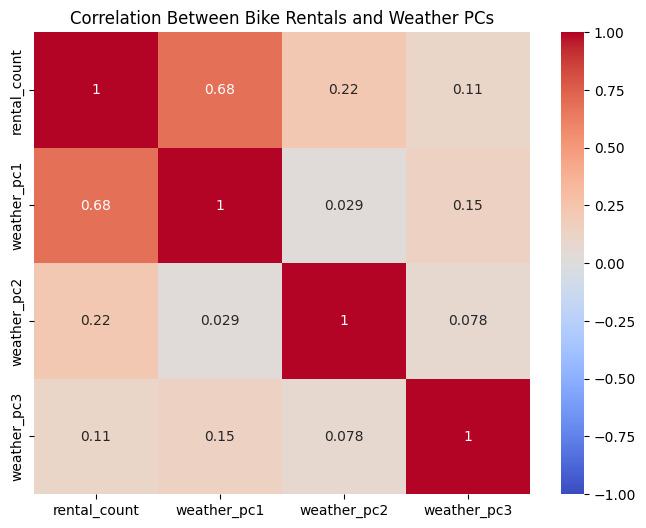


Correlation Interpretation:
weather_pc1: 0.684 (positive correlation)
weather_pc2: 0.220 (positive correlation)
weather_pc3: 0.106 (positive correlation)


In [26]:
# Correlation matrix between rentals and PCs
correlations = merged_data[['rental_count', 'weather_pc1', 'weather_pc2', 'weather_pc3']].corr()
# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Between Bike Rentals and Weather PCs")
plt.show() 

# Print interpretation
print("\nCorrelation Interpretation:")
for pc in [f'weather_pc{i+1}' for i in range(n_optimal)]:
    corr = correlations.loc['rental_count', pc]
    print(f"{pc}: {corr:.3f} ({'positive' if corr > 0 else 'negative'} correlation)")


Key Insights:
- weather_pc1: strong increases rentals (r = 0.68)
- weather_pc2: weak increases rentals (r = 0.22)
- weather_pc3: weak increases rentals (r = 0.11)


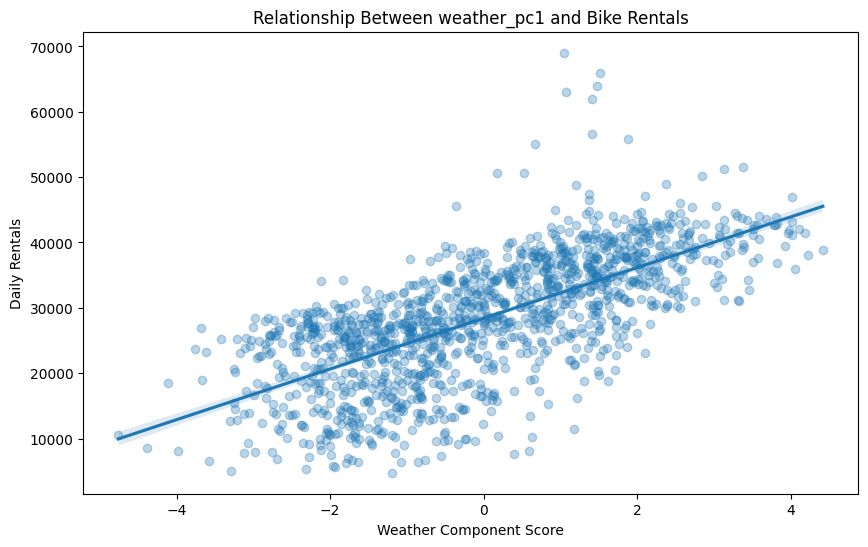

In [27]:
# Interpret the strongest correlations
print("\nKey Insights:")
for pc in ['weather_pc1', 'weather_pc2', 'weather_pc3']:
    corr = correlations.loc['rental_count', pc]
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    direction = "increases" if corr > 0 else "decreases"
    print(f"- {pc}: {strength} {direction} rentals (r = {corr:.2f})")

# Scatter plots for top correlations
top_pc = correlations.loc['rental_count'][1:].abs().idxmax()
plt.figure(figsize=(10, 6))
sns.regplot(x=top_pc, y='rental_count', data=merged_data, scatter_kws={'alpha':0.3})
plt.title(f"Relationship Between {top_pc} and Bike Rentals")
plt.xlabel("Weather Component Score")
plt.ylabel("Daily Rentals")
plt.show()

### Feature engineering:  (THIS HAS TO BE DONE AGAIN BC OF THE CHANGES)
We'll transform raw data to better predict rentals:

Temperature:

    Linear term (tavg) → Measures constant rate of change

    Quadratic term (tavg_squared) → Captures "too hot" or "too cold" effects

Precipitation:

    Binary heavy_rain flag for >5mm days (more impactful than drizzle)

Lagged terms: Accounts for temporal dependencies

In [ ]:
# Convert 'date' column to datetime if it's not already
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Temperature Effects (Nonlinear)
merged_data['tavg_squared'] = merged_data['tavg'] ** 2  # Polynomial term

# 2. Precipitation Impact (Binary Threshold)
merged_data['heavy_rain'] = (merged_data['prcp'] > 5).astype(int)  # Optimization-based threshold

# 3. Temporal Features
merged_data['is_weekend'] = merged_data['date'].dt.dayofweek.isin([5, 6]).astype(int)
merged_data['month'] = merged_data['date'].dt.month  # Seasonality
# 4. Lagged Weather (Time Dependency)
merged_data['tavg_lag1'] = merged_data['tavg'].shift(1)  # Previous day's temp
merged_data['prcp_lag1'] = merged_data['prcp'].shift(1)  # Previous day's rain

# Drop rows with missing values
merged_data = merged_data.dropna()


Train-test split

In [ ]:
# Split into train (2017-2018) and test (2019-2020)
train = merged_data[merged_data['date'].dt.year.isin([2017, 2018])]
test = merged_data[merged_data['date'].dt.year >= 2019]

# Define features and target
features = [
    'tavg', 'tavg_squared',  # Linear + Nonlinear temp
    'heavy_rain', 'prcp_lag1',  # Precipitation effects
    'wspd',  # Wind speed
    'is_weekend', 'month'  # Temporal controls
]
X_train, y_train = train[features], train['rental_count']
X_test, y_test = test[features], test['rental_count']

Linear regression and evaluation

In [ ]:
# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
test['predicted'] = model.predict(X_test)
mae = mean_absolute_error(y_test, test['predicted'])
r2 = r2_score(y_test, test['predicted'])

print(f"MAE: {mae:.0f} rentals")
print(f"R²: {r2:.2f} (1.0 is perfect)")

MAE: 5614 rentals
R²: 0.40 (1.0 is perfect)


C:\Users\jorri\AppData\Local\Temp\ipykernel_4376\273668455.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = model.predict(X_test)



Feature Impacts:
        feature       impact
0          tavg  1088.467270
1  tavg_squared     3.632186
3     prcp_lag1   -70.532638
6         month  -149.215754
4          wspd  -219.365501
2    heavy_rain -3556.520904
5    is_weekend -7079.859230


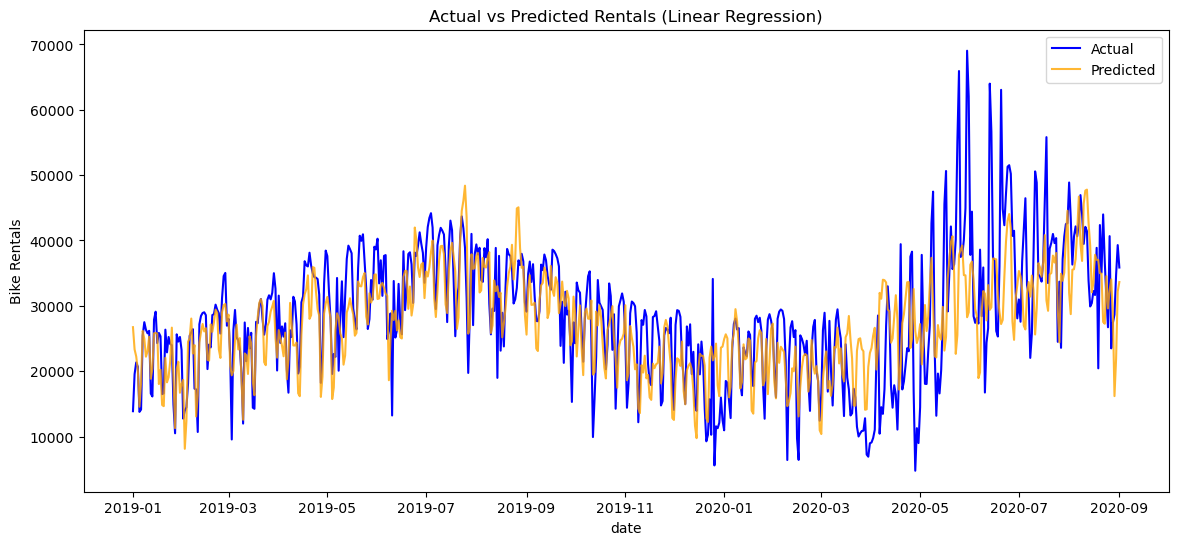

In [ ]:
# Get coefficients
coefs = pd.DataFrame({
    'feature': features,
    'impact': model.coef_
}).sort_values('impact', ascending=False)

print("\nFeature Impacts:")
print(coefs)

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
sns.lineplot(data=test, x='date', y='rental_count', label='Actual', color='blue')
sns.lineplot(data=test, x='date', y='predicted', label='Predicted', color='orange', alpha=0.8)
plt.title("Actual vs Predicted Rentals (Linear Regression)")
plt.ylabel("Bike Rentals")
plt.legend()
plt.show()

#### Problem Diagnosis:
Poor Performance Indicators:

- MAE (5614): Predictions are off by ~5,614 rentals/day (very high for London's system).

- R² (0.40): Only 40% of rental variance is explained by your model.

Suspicious Coefficients:

- is_weekend: -7079 → Implies weekends have fewer rentals than weekdays (contradicts real-world logic!)

- month: -149 → Rentals decrease every month (nonsensical trend)

- tavg: +1088 → Each 1°C increase → 1,088 more rentals (unrealistically large)


### Regression

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

merged_rentals_weather = pd.merge(daily_rentals_filtered, weather_df_filtered.loc[:, 'tavg':'date'], on='date', how='inner')
X = merged_rentals_weather.loc[:, 'tavg':'pres']
Y = merged_rentals_weather.loc[:, 'rental_count']

# create the test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# scale and center the data
scalerX = StandardScaler()

X0_train = scalerX.fit_transform(X_train)

#### Least-squares
A general regression problem can be written as: $y = f(\mathbf{x})$  with $y \in \mathbb{R}$, $x \in \mathbb{R}^d$ and $f: \mathbb{R}^d \mapsto \mathbb{R}$.
In linear regression, the function is represented by an array of weights: $y = \mathbf{w}^T \mathbf{x} = \sum_{i}^d w_i x_i$.

We need to tune the weights to our process, so we collect some data on the inputs $\mathbf{x}$ and the target $y$. The objective is to tune the weights to minimize the euclidean distance between the observations $\mathbf{y} \in \mathbb{R}^n$ and the predictions $\mathbf{X} \mathbf{w}$:

$\mathbf{w} = \underset{\mathbf{w}}{\mathrm{min}} ||\mathbf{X}\mathbf{w} - \mathbf{y}||^2_2$

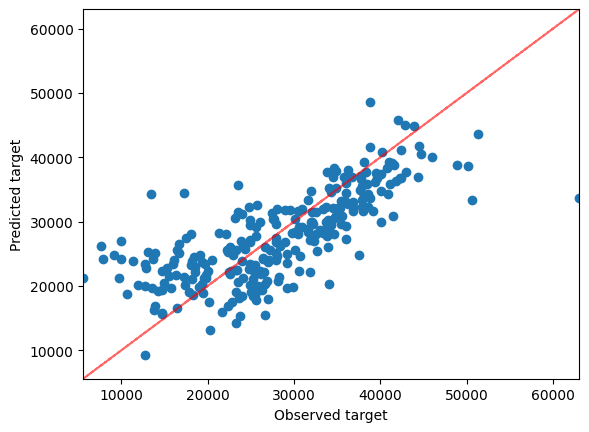

R2 for OLS is: 0.55
MSE for OLS is: 40266262.02
RMSE for OLS is: 6345.57


In [43]:
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression

# Create the linear regression object
OLS_reg = LinearRegression().fit(X0_train, y_train)

# To test the regression, we need to scale and center also the test data
X0_test = scalerX.transform(X_test)
y_pred_OLS = OLS_reg.predict(X0_test)

plt.scatter(y_test, y_pred_OLS)
plt.plot(y_test, y_test, c='r', alpha=0.6, ls='--')
plt.xlim(y_test.min()-5, y_test.max()+5)
plt.ylim(y_test.min()-5, y_test.max()+5)
plt.xlabel('Observed target')
plt.ylabel('Predicted target')
plt.show()

from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

r2_ols = r2_score(y_test, y_pred_OLS)
mse_ols = mean_squared_error(y_test, y_pred_OLS)
rmse_ols = root_mean_squared_error(y_test, y_pred_OLS)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'MSE for OLS is: {mse_ols:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')

#### Lasso regression with cross validation

In the OLS regression model we have included all the input features. However, if some features are not correlated with the output this can decrease the accuracy of the model. The LASSO regression model penalizes the coefficients that are different from zero, forcing the weights to be active only if they improve the model.

The objective function of the LASSO regression problem is:

$\mathbf{w} = \underset{\mathbf{w}}{\mathrm{min}} \frac{1}{2 n} ||\mathbf{X}\mathbf{w} - \mathbf{y}||^2_2 + \alpha ||\mathbf{w}||_1$

In which the coefficient $\alpha$ controls how much we regularize the model.

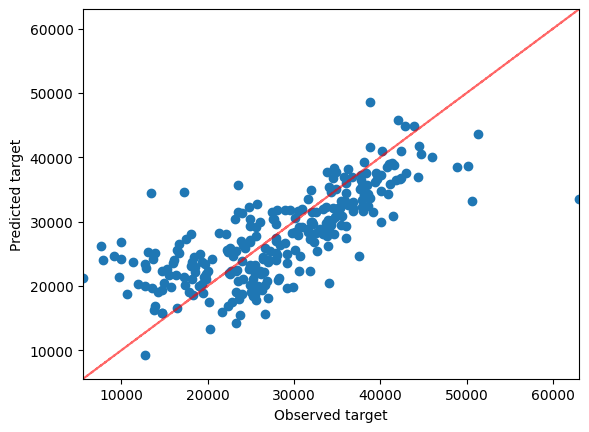

LS coefficients: 
[ 8279.266 -4705.578  2818.72   -212.395  -168.815   338.08   -755.483
   828.98 ]
LassoCV coefficients: 
[ 7127.284 -4122.598  3415.43   -218.727  -165.586   338.219  -747.129
   827.728]
R2 for OLS is: 0.55
R2 for LassoCV is: 0.55
RMSE for OLS is: 6345.57
RMSE for LassoCV is: 6344.33
alpha = 6.88


In [47]:
from sklearn.linear_model import LassoCV

LassoCV_reg = LassoCV(cv=5, random_state=42).fit(X0_train, y_train)
y_pred_lassoCV = LassoCV_reg.predict(X0_test)

plt.scatter(y_test, y_pred_lassoCV)
plt.plot(y_test, y_test, c='r', alpha=0.6, ls='--')
plt.xlim(y_test.min()-1, y_test.max()+1)
plt.ylim(y_test.min()-1, y_test.max()+1)
plt.xlabel('Observed target')
plt.ylabel('Predicted target')
plt.show()

print('LS coefficients: ')
print(np.round(OLS_reg.coef_, 3))

print('LassoCV coefficients: ')
print(np.round(LassoCV_reg.coef_, 3))

r2_lassoCV = r2_score(y_test, y_pred_lassoCV)
rmse_lassoCV = root_mean_squared_error(y_test, y_pred_lassoCV)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'R2 for LassoCV is: {r2_lassoCV:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')
print(f'RMSE for LassoCV is: {rmse_lassoCV:.2f}')

print(f'alpha = {LassoCV_reg.alpha_:.2f}')

Conclusion: doesn't change that much

#### Ridge regression

In Ridge regression, the regularization is applied to the $l_2$ norm of the weights. We want to reduce the magnitude of the weights, so that the model is less sensitive to noise.
The objective function of a Ridge regression problem is:

$\mathbf{w} = \underset{\mathbf{w}}{\mathrm{min}} ||\mathbf{X}\mathbf{w} - \mathbf{y}||^2_2 + \alpha ||\mathbf{w}||_2$

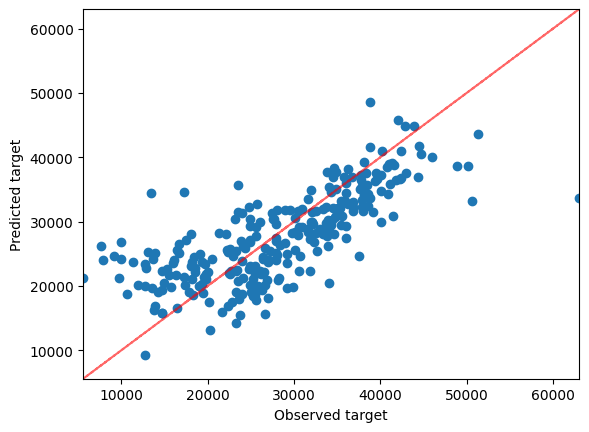

OLS coefficients: 
[ 8279.266 -4705.578  2818.72   -212.395  -168.815   338.08   -755.483
   828.98 ]
RidgeCV coefficients: 
[ 7054.762 -4122.852  3488.668  -222.849  -171.301   347.08   -748.71
   826.256]
R2 for OLS is: 0.55
R2 for RidgeCV is: 0.55
RMSE for OLS is: 6345.57
RMSE for RidgeCV is: 6342.62
alpha = 1.00


In [48]:
from sklearn.linear_model import RidgeCV

RidgeCV_reg = RidgeCV(alphas=(0.1, 0.5, 1, 5, 10, 50), cv=5).fit(X0_train, y_train)
y_pred_RidgeCV = RidgeCV_reg.predict(X0_test)

plt.scatter(y_test, y_pred_RidgeCV)
plt.plot(y_test, y_test, c='r', alpha=0.6, ls='--')
plt.xlim(y_test.min()-1, y_test.max()+1)
plt.ylim(y_test.min()-1, y_test.max()+1)
plt.xlabel('Observed target')
plt.ylabel('Predicted target')
plt.show()

print('OLS coefficients: ')
print(np.round(OLS_reg.coef_, 3))

print('RidgeCV coefficients: ')
print(np.round(RidgeCV_reg.coef_, 3))

r2_ridgeCV = r2_score(y_test, y_pred_RidgeCV)
rmse_ridgeCV = root_mean_squared_error(y_test, y_pred_RidgeCV)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'R2 for RidgeCV is: {r2_ridgeCV:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')
print(f'RMSE for RidgeCV is: {rmse_ridgeCV:.2f}')

print(f'alpha = {RidgeCV_reg.alpha_:.2f}')

Doesn't change much

#### Principal components regression

The principal component regression is the same as the OLS regression, with an extra-step: the PCA is applied to the X matrix, and the linear regression is performed on the new projected data.

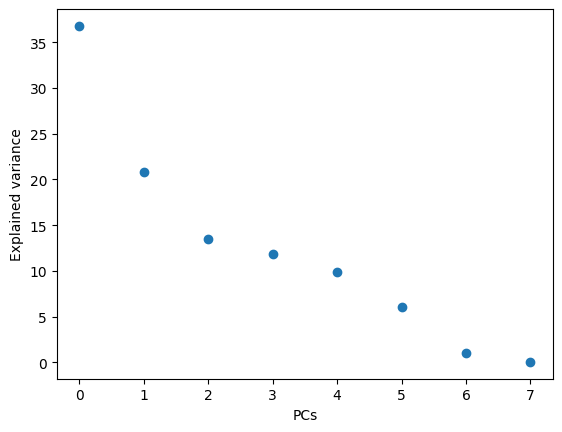

In [49]:
from sklearn.decomposition import PCA

pca = PCA().fit(X0_train)

plt.scatter(np.arange(X.shape[1]), pca.explained_variance_ratio_*100)
plt.xlabel('PCs')
plt.ylabel('Explained variance')
plt.show()

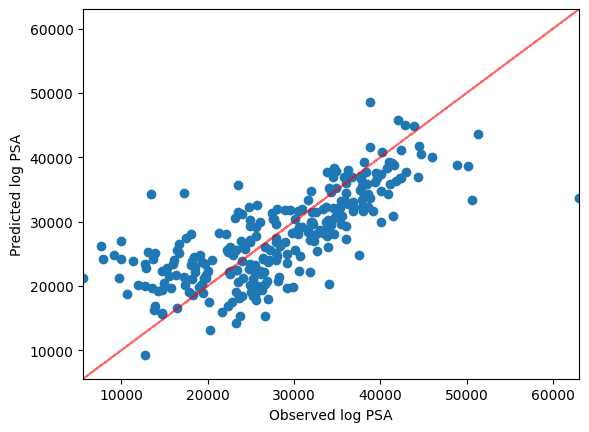

LS coefficients: 
[ 8279.266 -4705.578  2818.72   -212.395  -168.815   338.08   -755.483
   828.98 ]
PCR coefficients: 
[ 3868.243  1347.984  -180.545   -66.226   567.114   226.791 -5785.109
  7030.069]
R2 for OLS is: 0.55
R2 for PCR is: 0.55
RMSE for OLS is: 6345.57
RMSE for PCR is: 6345.57


In [ ]:
A_train = pca.components_.T
Z_train = X0_train @ A_train
Z_test = X0_test @ A_train

# The regression has to be applied to the PC scores
PCR_reg = LinearRegression().fit(Z_train, y_train)
y_pred_PCR = PCR_reg.predict(Z_test)

plt.scatter(y_test, y_pred_PCR)
plt.plot(y_test, y_test, c='r', alpha=0.6, ls='--')
plt.xlim(y_test.min()-1, y_test.max()+1)
plt.ylim(y_test.min()-1, y_test.max()+1)
plt.xlabel('Observed log PSA')
plt.ylabel('Predicted log PSA')
plt.show()

print('LS coefficients: ')
print(np.round(OLS_reg.coef_, 3))

print('PCR coefficients: ')
print(np.round(PCR_reg.coef_, 3))

r2_pcr = r2_score(y_test, y_pred_PCR)
rmse_PCR = root_mean_squared_error(y_test, y_pred_PCR)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'R2 for PCR is: {r2_pcr:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')
print(f'RMSE for PCR is: {rmse_PCR:.2f}')

# This is still exactly the same as OLS, because we take all PC's

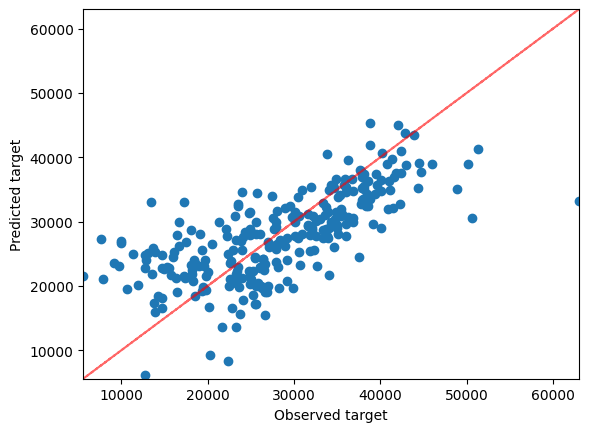

R2 for OLS is: 0.55
R2 for PCR is: 0.49
RMSE for OLS is: 6345.57
RMSE for PCR is: 6790.15


In [ ]:
# We can test the regression with fewer features, let's say 3
q = 3
Z_train = X0_train @ A_train[:,:q]
Z_test = X0_test @ A_train[:,:q]

PCR_reg = LinearRegression().fit(Z_train, y_train)
y_pred_PCR = PCR_reg.predict(Z_test)

plt.scatter(y_test, y_pred_PCR)
plt.plot(y_test, y_test, c='r', alpha=0.6, ls='--')
plt.xlim(y_test.min()-1, y_test.max()+1)
plt.ylim(y_test.min()-1, y_test.max()+1)
plt.xlabel('Observed target')
plt.ylabel('Predicted target')
plt.show()

r2_pcr = r2_score(y_test, y_pred_PCR)
rmse_PCR = root_mean_squared_error(y_test, y_pred_PCR)

print(f'R2 for OLS is: {r2_ols:.2f}')
print(f'R2 for PCR is: {r2_pcr:.2f}')
print(f'RMSE for OLS is: {rmse_ols:.2f}')
print(f'RMSE for PCR is: {rmse_PCR:.2f}')

Ofcourse this is 'worse', but we only take into account 3 out of 8 PC's, so it is actually kind of okay I would say